In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a Type

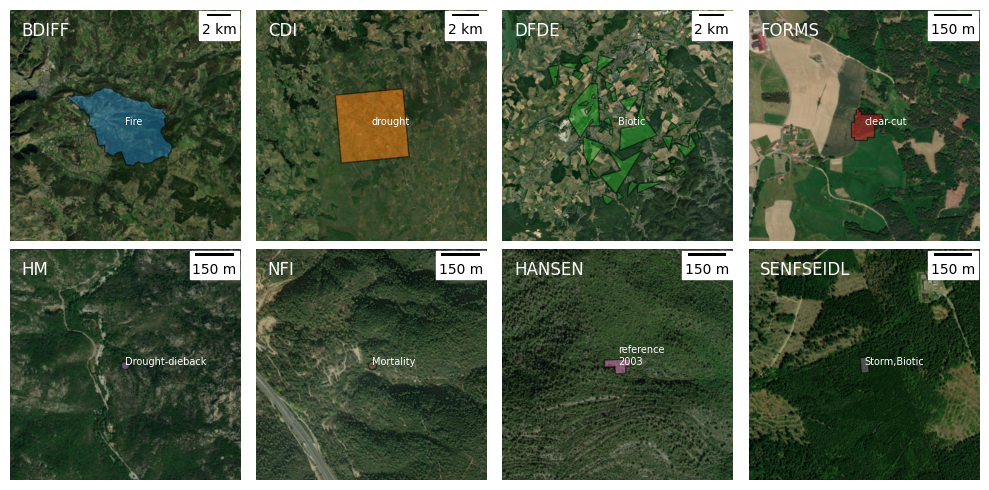

In [2]:
import seaborn as sns
import contextily as ctx
from constants import DCLASS_SCORE, custom_color_mapping
from matplotlib_scalebar.scalebar import ScaleBar


# Convert nested dictionary into a DataFrame for seaborn plotting
data = []
for dataset, classes in DCLASS_SCORE.items():
    for class_name, scores in classes.items():
        for final_class, score in scores.items():
            data.append({'Dataset': dataset, 'Class': class_name, 'Final Class': final_class, 'Score': score})

df = pd.DataFrame(data)

# Set the color palette to custom colors
final_classes = ['fire', 'storm', 'biotic-dieback', 'biotic-mortality', 'drought-dieback', 'anthropogenic']
palette = sns.color_palette([custom_color_mapping[fc] for fc in sorted(final_classes) if fc in custom_color_mapping])

# Creating a figure with 4 columns and 4 rows for the 8 datasets
# Each dataset occupies one column and two rows
def bar_plot(dataframe, ax, palette):
    a = dataframe.sort_values('Final Class').pivot_table(index=['Dataset', 'Class'], columns='Final Class', values='Score', fill_value=0)
    if dataframe['Final Class'].nunique() == 1:
        c = custom_color_mapping[dataframe['Final Class'].iloc[0]]
    else :
        c = palette

    a.reset_index().plot.bar(x='Class', stacked=True, ax=ax, color=c, legend=False)
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms, 'reference':tcl}
#---- plot ---- 
import matplotlib.pyplot as plt
# Creating a figure with 4 columns and 4 rows for the 8 datasets
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))

import numpy as np 
# Grouping by 'Dataset' and enumerating over these groups
for i, (dataset, dataset_df) in enumerate(df.groupby('Dataset')):
    # Calculating the position for the plots in the grid
    col = i % 4
    row = i // 4 

    if col == 0:
        # Setting up the labels for the rows
        axs[row, col].set_ylabel('Data example')
        # axs[row + 1, col].set_ylabel('Composition of dataset classes')

    # Setting up the plots
    d = ddataset[dataset].sample(n=1)
    #square buffer around the centroid of the polygon
    area = d.iloc[0].geometry.area
    if area > 10000:
        ed = np.sqrt(area / np.pi)
    else : 
        ed = 150
    
    extent = d.centroid.buffer(3 * ed, cap_style = 3).total_bounds
    #define xlim and ylim
    xlim = (extent[0], extent[2])
    ylim = (extent[1], extent[3])
    axs[row, col].set_xlim(xlim)
    axs[row, col].set_ylim(ylim)
    axs[row, col].add_artist(ScaleBar(1))
    #add scale bar
    d.plot(ax=axs[row, col], alpha=0.5, edgecolor='k', color=f'C{i}')
    ctx.add_basemap(axs[row, col], crs=d.crs.to_string(), source=ctx.providers.Esri.WorldImagery, attribution=False)

    #add tex annotation of d['class'] at the centroid 
    if dataset == 'reference':
        dataset = 'Hansen'
        txt = 'reference' + '\n' + str(d['year'].iloc[0])
    else :
        txt = d['class'].iloc[0]  #+ '\n' + d['start_date'].dt.strftime('%Y-%m-%d').iloc[0] + '\n' + d['end_date'].dt.strftime('%Y-%m-%d').iloc[0]
    axs[row, col].text(d.centroid.x, d.centroid.y, txt, fontsize=7, color='white')
    axs[row, col].axis('off')

    
    #annotate name of the dataste in the left top corner with transAx coordinates between 0 and 1
    axs[row, col].annotate(dataset.upper(), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, ha='left', va='top', color='white')

    # bar_plot(dataset_df, axs[row + 1, col], palette)
    # axs[row + 1, col].set_title(dataset.upper(), fontsize=12)


# Displaying the updated template
plt.tight_layout()
plt.show()



In [3]:
#autoreload 
from attribution import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

# dspatial_f = {'dfde': (3000, 0), 'hm': (1000, 0), 'nfi': (3000, 600), 'senfseidl': (500, 0), 'bdiff': (500, 0), 'cdi':(3000, 0), 'forms':(500, 0)}
# dtemporal_f = {'dfde': (365, 0), 'hm': (180, 0), 'nfi': (2.5 * 365, 0), 'senfseidl': (180, 0), 'bdiff': (180, 0), 'cdi':(180, 0), 'forms':(180, 0)} 

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': 1., 'bdiff': 1.0, 'cdi':1.0, 'forms':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 174.72 km2, median : 25.00 km2
senfseidl  -  Storm,Biotic
senfseidl  -  Fire
senfseidl  -  Other
dfde  -  Biotic
dfde  -  Storm
dfde  -  Fire
dfde  -  Drought
dfde  -  Other
nfi  -  Mortality
nfi  -  Storm
nfi  -  Fire
nfi  -  Other
nfi  -  Anthropogenic
hm  -  Biotic-mortality
hm  -  Biotic-dieback
hm  -  Storm
hm  -  Fire
hm  -  Drought-dieback
hm  -  Other
cdi  -  drought
forms  -  clear-cut
bdiff  -  Fire
reference  -  None


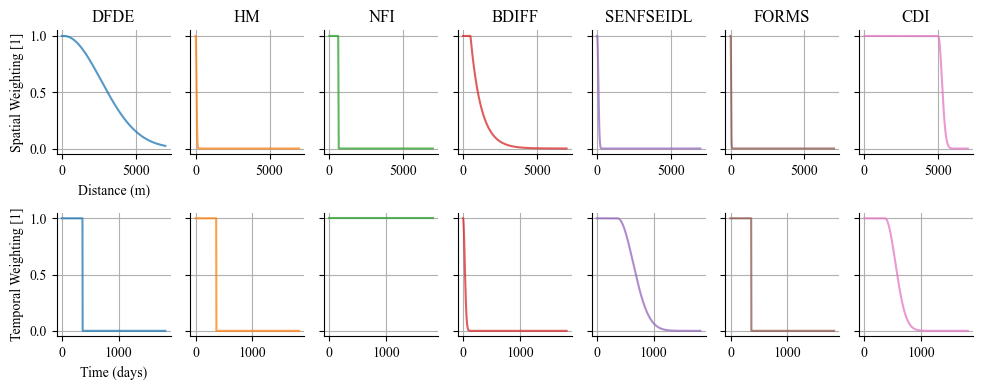

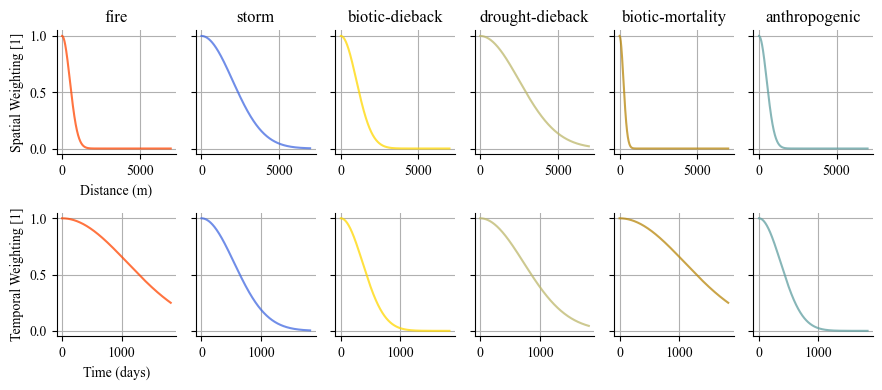

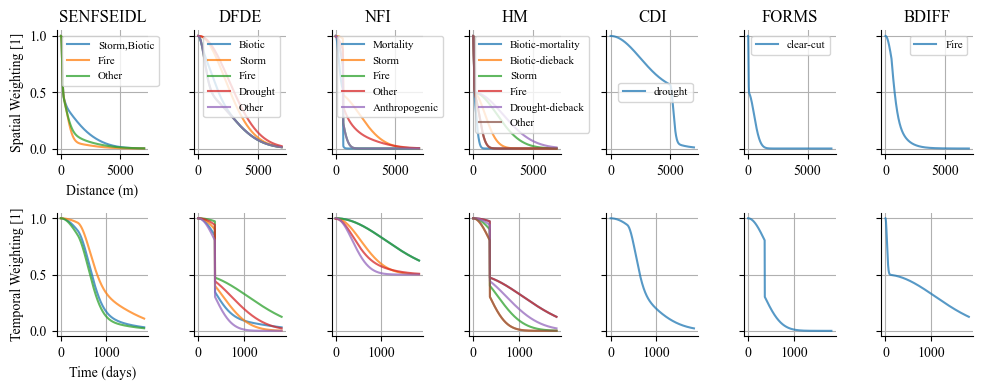

In [4]:
a, b , c = attribution.plot_weighting_functions(title=False)

In [5]:
a.savefig(fname='../figures/dataset_profiles.png', dpi=300, bbox_inches='tight')
b.savefig(fname='../figures/disturbance_profiles.png', dpi=300, bbox_inches='tight')
c.savefig(fname='../figures/weighting_functions.png', dpi=300, bbox_inches='tight')

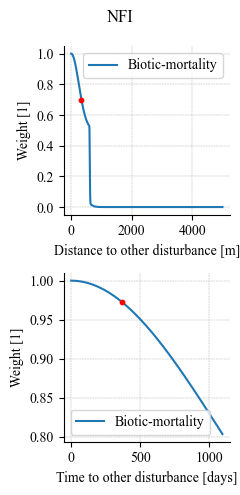

In [26]:
dataset = 'nfi'
c = 'Mortality'
import numpy as np
xs = np.linspace(0, 5000, 1000)
xt = np.linspace(0, 365 * 3, 1000)
xs_ = 340
xt_ = 365 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2.5, 5))
axs[0].plot(xs, [attribution.final_weighting_dict[dataset][c]['spatial'](x) for x in xs], label='Biotic-mortality')
axs[0].set_xlabel('Distance to other disturbance [m]')
axs[0].set_ylabel('Weight [1]')
axs[0].scatter([xs_], [attribution.final_weighting_dict[dataset][c]['spatial'](xs_)], c='r', s=10, zorder=10)

axs[1].plot(xt, [attribution.final_weighting_dict[dataset][c]['temporal'](x) for x in xt], label='Biotic-mortality')
axs[1].set_xlabel('Time to other disturbance [days]')
axs[1].set_ylabel('Weight [1]')
axs[1].scatter([xt_], [attribution.final_weighting_dict[dataset][c]['temporal'](xt_)], c='r', s=10, zorder=10)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    ax.grid(lw=0.35, linestyle='--')

fig.suptitle(dataset.upper())
plt.tight_layout()
fig.savefig(fname=f'../figures/{dataset}_{c}_{xs_}m_{xt_}d.png', dpi=300, bbox_inches='tight')

In [5]:
pd.options.mode.chained_assignment = None
import time 

from utils import compute_tree_coherence, compute_class_similarity
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': DCLASS_SCORE}, 1.0)}

for year in range(2017, 2021):
    print(f'year : {year}')
    attribution.get_clusters(year, dcustom_similiraity_function=dcustom_similarity_function, dir_=f'../data/results/cluster_{year}')
    time.sleep(180)

year : 2017
number of groups : 114118, estimated time (4 cores) = 57.059 min


100%|██████████| 12/12 [54:36<00:00, 273.08s/it]


year : 2018
number of groups : 94341, estimated time (4 cores) = 47.170500000000004 min


100%|██████████| 10/10 [43:41<00:00, 262.19s/it]


year : 2019
number of groups : 100737, estimated time (4 cores) = 50.368500000000004 min


100%|██████████| 11/11 [46:03<00:00, 251.25s/it]


year : 2020
number of groups : 105803, estimated time (4 cores) = 52.9015 min


100%|██████████| 11/11 [3:56:52<00:00, 1292.02s/it]
